In [1]:
import pandas as pd
import pandas as pd
import seaborn as sns
import math
import re
import warnings
from pandas_profiling import ProfileReport
import missingno as msno
import os
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
warnings.filterwarnings("ignore")

# pandasgui X sweetviz X pandas profiling:
# https://towardsdatascience.com/data-frame-eda-packages-comparison-pandas-profiling-sweetviz-and-pandasgui-bbab4841943b#:~:text=Sweetviz%20is%20another%20Sweetviz%20is,fully%20self%2Dcontained%20HTML%20application.

/tmp/ipykernel_214751/728095207.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-06-19 00:47:53.176195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-19 00:47:53.176274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-19 00:47:53.279980: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-19 00:47:55.225613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object fi

# 1) Get data

In [2]:
def read_data():
    train_data = pd.read_csv("./data/train.csv")
    print("Train data imported successfully!!")
    print("-"*50)
    test_data = pd.read_csv("./data/test.csv")
    print("Test data imported successfully!!")
    return train_data , test_data

raw_train_data , raw_test_data = read_data()

Train data imported successfully!!
--------------------------------------------------
Test data imported successfully!!


# 2) Exploratory data analysis & preprocessing:

In [3]:
raw_train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
raw_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2.1) Feature Engineering

Binary encode gender (male & female → 1 & 0)

In [41]:
# merging train and test data into one big dataframe
raw_all_data = pd.concat([raw_train_data , raw_test_data])

all_data_gender_binary_encoded = raw_all_data.copy()
all_data_gender_binary_encoded['Sex'] = raw_all_data['Sex'].replace({'male': 1, 'female': 0})

### 2.1.1) Normalizing features

In [42]:
# Define scaler to set values to mean 0 and std. dev. = 1
scaler = StandardScaler()

normalize_columns = [ 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare' ]
all_data_normalized = pd.DataFrame(scaler.fit_transform(all_data_gender_binary_encoded[normalize_columns]), columns = normalize_columns)

all_data_gender_binary_encoded.reset_index(drop=True, inplace=True)
all_data_normalized['Name'] = all_data_gender_binary_encoded['Name']
all_data_normalized['Ticket'] = all_data_gender_binary_encoded['Ticket']
all_data_normalized['Cabin'] = all_data_gender_binary_encoded['Cabin']
all_data_normalized['Embarked'] = all_data_gender_binary_encoded['Embarked']

### 2.1.2) Create Titles feature

In [43]:
all_data_with_titles = all_data_normalized.copy()

name_regex_pattern = "(.*?)\,\s([^.]*)\.\s([^(]*)(\(([^\"]*)\))?"
cabin_regex_pattern = "^(\w).*"

def create_titles(name):
    actual_title = re.search(name_regex_pattern, name).group(2)
    match actual_title:
        case "Ms":
            return "Mrs"
        case "Mlle":
            return "Miss"
        case "Mme":
            return "Mrs"
        case "Major":
            return "Militar"
        case "Col":
            return "Militar"
        case "Capt":
            return "Militar"
        case "the Countess":
            return "Noble"
        case "Lady":
            return "Noble"
        case "Sir":
            return "Noble"
        case "Don":
            return "Noble"
        case "Dona":
            return "Noble"
        case "Jonkheer":
            return "Noble"
        case _:
            return actual_title

# Extract the titles from the names column
all_data_with_titles['Titles'] = all_data_with_titles['Name'].apply(create_titles)

In [47]:
print(all_data_with_titles['Titles'].value_counts())

# One-hot encode the "Titles" column
all_data_with_titles_one_hot_encoded = pd.get_dummies(all_data_with_titles, columns=['Titles'])

Mr         757
Miss       262
Mrs        200
Master      61
Rev          8
Dr           8
Militar      7
Noble        6
Name: Titles, dtype: int64


## 2.2) Discovering & Imputing null data

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64


<AxesSubplot:>

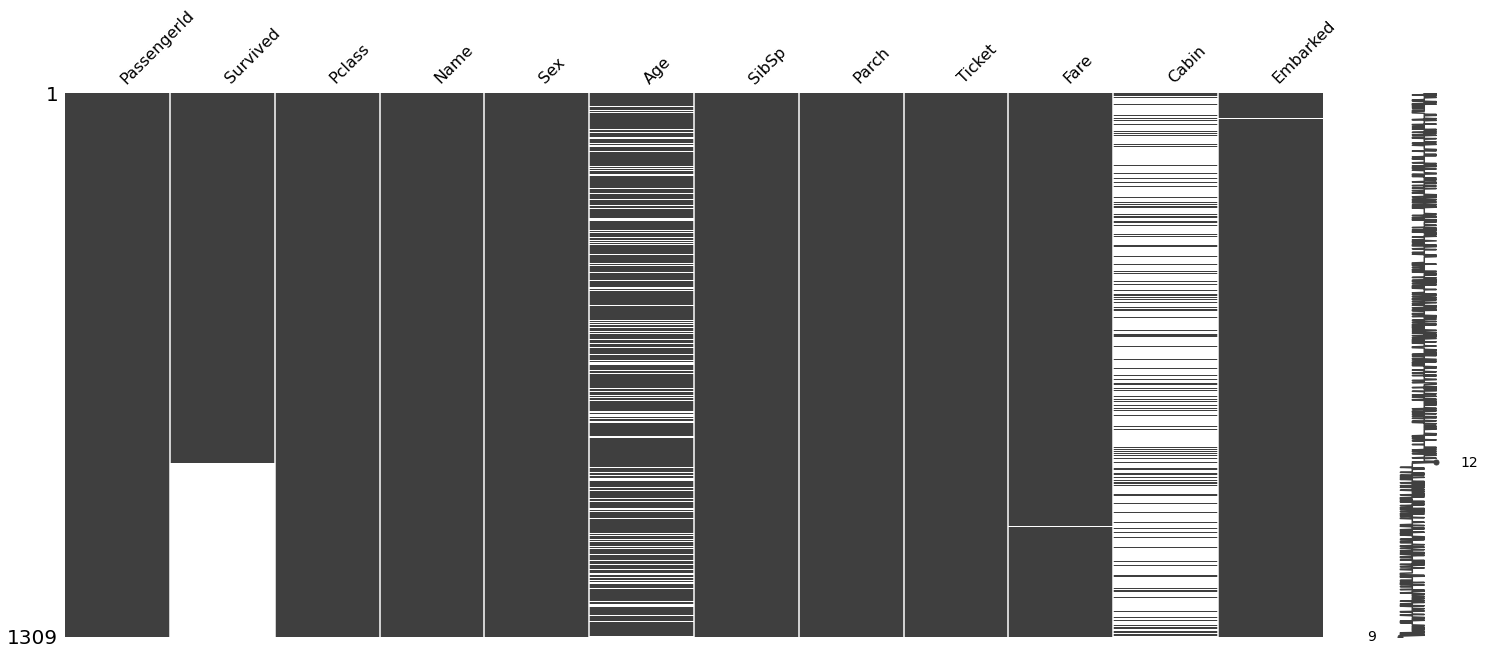

In [7]:
print(raw_all_data.isnull().mean()*100)

msno.matrix(raw_all_data)

### 2.2.1) Impute Embarked (manually)

Embarked is a categorial feature ("Q", "S", "C") with two missing values, so we can't really use it (as far as i know) on KNN, like we did below with Fare, so we're just going to do a simple approach and impute it with the most common value it has. 

S    914
C    270
Q    123
Name: Embarked, dtype: int64


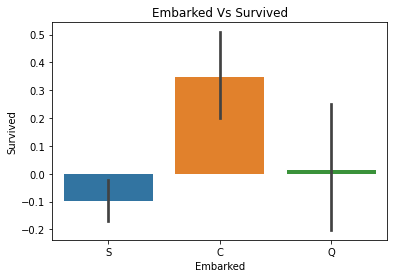

In [49]:
import matplotlib.pyplot as plt

def survived_bar_plot(feature):
    plt.figure(figsize = (6,4))
    sns.barplot(data = all_data_with_titles_one_hot_encoded , x = feature , y = "Survived").set_title(f"{feature} Vs Survived")
    plt.show()

print(all_data_with_titles_one_hot_encoded['Embarked'].value_counts())
survived_bar_plot("Embarked")


In [50]:
all_data_with_embarked_imputed = all_data_with_titles_one_hot_encoded.copy()
all_data_with_embarked_imputed["Embarked"] = all_data_with_embarked_imputed['Embarked'].fillna('S')
all_data_with_embarked_imputed["Embarked"].isnull().any()

False

### 2.2.2) Impute Fare (with KNN)

In [51]:
#One-hot encoding Embarked
all_data_with_embarked_one_hot_encoded = pd.get_dummies(all_data_with_embarked_imputed, columns=['Embarked'])
print(all_data_with_embarked_one_hot_encoded.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Name',
       'Ticket', 'Cabin', 'Titles_Dr', 'Titles_Master', 'Titles_Militar',
       'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Noble', 'Titles_Rev',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [52]:
all_data_with_fare_imputed = all_data_with_embarked_one_hot_encoded.copy()
# Define the features and target variables
features = ['Fare', 'SibSp', 'Parch', 'Pclass', 'Titles_Militar', 'Titles_Dr', 'Titles_Noble',
            'Titles_Master', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Rev', 'Embarked_C',
            'Embarked_Q', 'Embarked_S']

#Define a subset of the dataset (text features don't work with KNN)
data_knn = all_data_with_fare_imputed.filter(features, axis=1).copy()
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Define KNN imputer and fill missing values
tdx_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(data_knn), columns=data_knn.columns)

all_data_with_fare_imputed['Fare'] = tdx_knn_imputed['Fare']
all_data_with_fare_imputed["Fare"].isnull().any()

False

### 2.2.3) Impute Age (with random forest regressor)

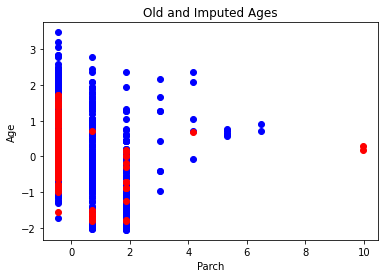

In [53]:
#Define a subset of the dataset (text features don't work with KNN)
from sklearn.ensemble import RandomForestRegressor
import numpy as np

all_data_with_age_imputed = all_data_with_fare_imputed.copy()
# data_knn = all_data.filter(['Fare','Age','SibSp','Parch', 'Pclass', 'Titles'], axis=1).copy()
# knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Define scaler to set values between 0 and 1
scaler = StandardScaler()

# Split the data into training and test sets
train_age_imputation_data = all_data_with_age_imputed[~all_data_with_age_imputed['Age'].isnull()]
test_age_imputation_data = all_data_with_age_imputed[all_data_with_age_imputed['Age'].isnull()]

# Define the features and target variables
features = ['Fare', 'SibSp', 'Parch', 'Pclass', 'Titles_Militar', 'Titles_Dr', 'Titles_Noble',
            'Titles_Master', 'Titles_Miss', 'Titles_Mr', 'Titles_Mrs', 'Titles_Rev', 'Embarked_C',
            'Embarked_Q', 'Embarked_S']
target = 'Age'

# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(train_age_imputation_data[features], train_age_imputation_data[target])

data_imputed = test_age_imputation_data.copy()
# Use the model to predict missing Age values in the test set
predicted_ages = model.predict(test_age_imputation_data[features])

# Fill in the missing Age values with the predicted values
all_data_with_age_imputed.loc[all_data_with_age_imputed['Age'].isnull(), 'Age'] = predicted_ages


# Plot the old ages in blue
plt.scatter(train_age_imputation_data['Parch'], train_age_imputation_data['Age'], color='blue')

# Plot the newly imputed ages in red
plt.scatter(test_age_imputation_data['Parch'], predicted_ages, color='red')

# Add axis labels and a title
plt.xlabel('Parch')
plt.ylabel('Age')
plt.title('Old and Imputed Ages')

# Show the plot
plt.show()


In [54]:
all_data_with_age_imputed["Age"].isnull().any()

False

## 2.3) Feature selection (Dropping useless columns)

In [55]:
all_data_processed = all_data_with_age_imputed.copy()
all_data_processed.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)
print(all_data_processed.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Titles_Dr', 'Titles_Master', 'Titles_Militar', 'Titles_Miss',
       'Titles_Mr', 'Titles_Mrs', 'Titles_Noble', 'Titles_Rev', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


## 2.4) Split data for training

In [56]:
train_data_processed = all_data_processed[all_data_processed['Survived'].notnull()]

X = train_data_processed.iloc[:, 1:]
y = train_data_processed.iloc[:, 0].astype(int)

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2)

X_test = all_data_processed[all_data_processed['Survived'].isnull()]
X_test.drop(['Survived'], axis=1, inplace=True)

print(X.shape)
print(y.shape)
assert((X.columns == X_test.columns).all())

X_test.head()
y_train.info()

(891, 17)
(891,)
<class 'pandas.core.series.Series'>
Int64Index: 712 entries, 100 to 882
Series name: Survived
Non-Null Count  Dtype
--------------  -----
712 non-null    int64
dtypes: int64(1)
memory usage: 11.1 KB


# 3) Use predictive model

## 3.1) Create the model

In [11]:
# Create neural network

input_shape = (17,)
num_classes = 1
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        # keras.layers.Dropout(0.1),
        keras.layers.Dense(30, activation="relu", activity_regularizer=keras.regularizers.l2(0.1)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(num_classes, activation="sigmoid"),
    ]
)

learning_rate = 0.005
# opt = keras.optimizers.SGD(learning_rate=learning_rate)
opt = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model.
model.compile(
  optimizer=opt,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                540       
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 31        
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________
None


## 3.2) Train model

In [174]:
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
def scheduler(epoch):
  if epoch <= 100:
    return learning_rate
  else:
    return learning_rate / math.sqrt(epoch - 100)
callback = keras.callbacks.LearningRateScheduler(scheduler)

# in order to achieve the accuracy of 82%, this was run 4 times, totalling 400 epochs.
# The only things that changed was the batch size, which was respectivelly: 64, 64, 128, 209
results = model.fit(
  X_train,
  y_train,
  epochs=200,
  batch_size=256,
  validation_data=(X_cv, y_cv),
  verbose = 1,
  callbacks=[callback]
)


Epoch 1/200
3/3 [==============================] - 2s 246ms/step - loss: 1.1515 - accuracy: 0.5576 - val_loss: 1.0298 - val_accuracy: 0.5978 - lr: 0.0050
Epoch 2/200
3/3 [==============================] - 0s 37ms/step - loss: 1.0305 - accuracy: 0.5983 - val_loss: 0.9324 - val_accuracy: 0.6257 - lr: 0.0050
Epoch 3/200
3/3 [==============================] - 0s 33ms/step - loss: 0.9422 - accuracy: 0.6362 - val_loss: 0.8562 - val_accuracy: 0.6536 - lr: 0.0050
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 0.8675 - accuracy: 0.6713 - val_loss: 0.7964 - val_accuracy: 0.6872 - lr: 0.0050
Epoch 5/200
3/3 [==============================] - 0s 37ms/step - loss: 0.8028 - accuracy: 0.7008 - val_loss: 0.7493 - val_accuracy: 0.7207 - lr: 0.0050
Epoch 6/200
3/3 [==============================] - 0s 34ms/step - loss: 0.7554 - accuracy: 0.7163 - val_loss: 0.7116 - val_accuracy: 0.7542 - lr: 0.0050
Epoch 7/200
3/3 [==============================] - 0s 31ms/step - loss: 0.7209 - 

# 4) Model evaluation

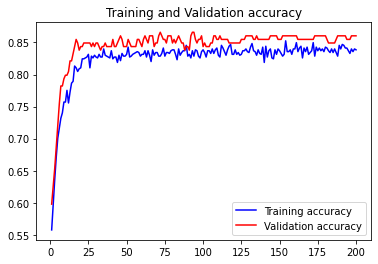

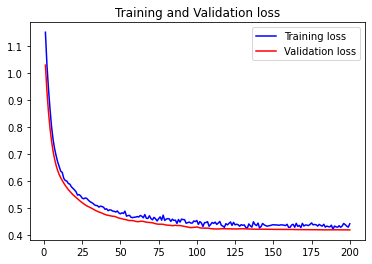

6/6 [==============================] - 0s 2ms/step


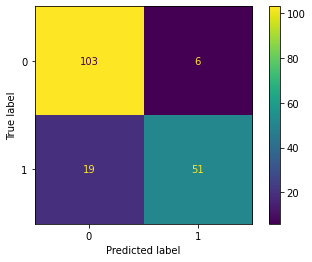

In [175]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# one-hot-encoding y set
y_cv_prediction = model.predict(X_cv)
y_cv_prediction_rounded = [round(x) for arr in y_cv_prediction for x in arr]
# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_cv, y_cv_prediction_rounded)


Create .csv file with predictions

In [176]:
y_test_prediction = model.predict(X_test)
y_test_prediction_rounded = pd.Series([round(x) for arr in y_test_prediction for x in arr], name='Survived')

test_ids = pd.Series(raw_test_data.iloc[:, 0]) # get only the ids from the test dataset
result=pd.concat([test_ids, y_test_prediction_rounded],axis=1)
result.to_csv('./solutions/kaggle_titanic.csv',index=False)


14/14 [==============================] - 0s 2ms/step
